/home/zhantao/.conda/envs/sqt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


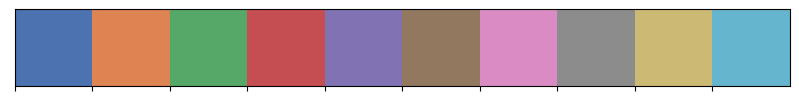

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_scatter
from tqdm import tqdm

import config_matplotlib
import seaborn as sns

cmap_global = sns.color_palette('deep')
sns.palplot(cmap_global)

In [2]:
def read_pkl_data(fname):
    with open(fname, 'rb') as f:
        data_dict = pickle.load(f)
    loss_abs = np.abs(data_dict['param_mean'] - data_dict['param_true'][:,None,:])
    loss_rel = (np.abs(data_dict['param_mean'] - data_dict['param_true'][:,None,:])) / np.abs(data_dict['param_true'][:,None,:])
    return loss_abs, loss_rel

In [3]:
def read_pkl_data_for_dict(fname):
    with open(fname, 'rb') as f:
        data_dict = pickle.load(f)
    param_mean_raw = []
    param_true = []
    for idx in data_dict.keys():
        # param_mean_raw.append(data_dict[idx]['param_mean'][None])
        param_mean_raw.append((data_dict[idx]['particles'] * data_dict[idx]['particle_weights'][:,None,:]).sum(axis=-1)[None])
        param_true.append(data_dict[idx]['param_true'][None])
    max_len = max([p.shape[1] for p in param_mean_raw])
    param_mean = []
    for p in param_mean_raw:
        if p.shape[0] < max_len:
            param_mean.append(np.concatenate([p, np.repeat(p[:,-1,None,:], max_len-p.shape[1], axis=1)], axis=1))
        else:
            param_mean.append(p)
    param_mean = np.vstack(param_mean)
    param_true = np.vstack(param_true)
    loss_abs = np.abs(param_mean - param_true[:,None,:])
    loss_rel = (np.abs(param_mean - param_true[:,None,:])) / np.abs(param_true[:,None,:])
    # loss_abs = np.abs(data_dict['param_mean'] - data_dict['param_true'][:,None,:])
    # loss_rel = (np.abs(data_dict['param_mean'] - data_dict['param_true'][:,None,:])) / np.abs(data_dict['param_true'][:,None,:])
    return loss_abs, loss_rel

In [4]:
Nb = 40
noise_level_list = [0.5, 1.0, 2.0]
pw_list = [0.1, 0.2]
datadir = 'benchmarks_2023Apr05'
task_labels = ['gd', 'baseline', 'sequential', 'random']
run_labels = [f'RUN_{i+1}' for i in range(5)]
scatter_mean_indices = torch.arange(len(task_labels)).repeat_interleave(len(run_labels))
print(scatter_mean_indices)

results = {}

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])


In [5]:
results = torch.load(os.path.join(datadir, "summarized_results.pt"))
print(results.keys())
print(results[(0.1,0.5)].keys())

dict_keys([(0.1, 0.5), (0.1, 1.0), (0.1, 2.0), (0.2, 0.5), (0.2, 1.0), (0.2, 2.0)])
dict_keys(['mean_loss_avg_over_runs_samples', 'std_loss_avg_over_runs_samples', 'loss_avg_over_runs', 'loss_full', 'loss_indices', 'param_true', 'times', 'signals', 'measured_settings', 'measured_values', 'times_finer', 'signals_finer'])


In [6]:
%load_ext autoreload
%autoreload 2

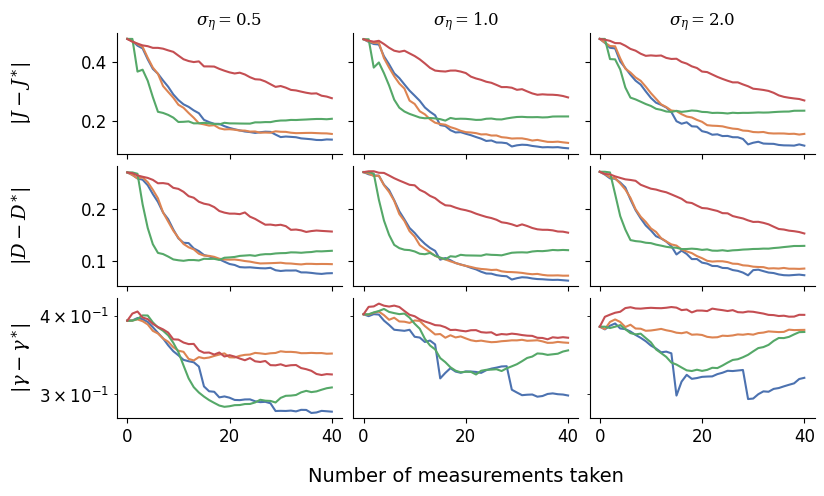

In [7]:
ylabels = ['J', 'D', '\gamma']
legends = ['Bayesian w. GD', 'Bayesian', 'Sequential', 'Random']
import matplotlib.gridspec as gridspec

# fig = plt.figure(figsize=(9,9))
# gs = fig.add_gridspec(3,3)
fig, axes = plt.subplots(nrows=3, ncols=3, sharex='col', sharey='row', figsize=(9, 5), gridspec_kw={"wspace": 0.05, "hspace": 0.1})
# for i_pw, pw in tqdm(enumerate(pw_list[:1])):

i_pw = 0
pw = pw_list[i_pw]
for i_nl, nl in enumerate(noise_level_list):
    # ax = fig.add_subplot(gs[i_pw, i_nl])
    loss_mean = results[(pw,nl)]['mean_loss_avg_over_runs_samples']
    for i_ax in range(3):
        ax = fig.add_subplot(axes[i_ax, i_nl])
        if i_nl == 0:
            ax.set_ylabel(rf'$|{ylabels[i_ax]}-{ylabels[i_ax]}^{{\ast}}|$')
        if i_ax == 2 and i_nl == 1:
            ax.set_xlabel("Number of measurements taken", labelpad=15)
        if i_ax == 0:
            ax.set_title(rf"$\sigma_{{\eta}}={nl:.1f}$")
    # axes_inner = gridspec.GridSpecFromSubplotSpec(3, 1,
    #                 subplot_spec=axes[i_pw, i_nl], wspace=0.1, hspace=0.1)
    # axes[i_pw, i_nl].set_xticks([])
    # axes[i_pw, i_nl].set_yticks([])
        # ax = fig.add_subplot(axes_inner[i_ax])
        for j, _mean in enumerate(loss_mean):
            if i_ax == 2:
                ax.semilogy(np.arange(_mean.shape[0]), _mean[...,i_ax], c=cmap_global[j], label=legends[j])
            else:
                ax.plot(np.arange(_mean.shape[0]), _mean[...,i_ax], c=cmap_global[j], label=legends[j])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # ax.set_yscale('linear')
            # if i_ax == 2:
            #     ax.set_yscale('log')
        # else:
        #     ax.set_yscale('linear')
        if i_pw == 3 and i_ax == 2 and i_nl == 2:
            ax.legend(loc='center left', bbox_to_anchor=(-2, -1), ncols=4)

fig.align_ylabels(axes[:,0])
plt.show()
# fig.savefig(f"figures/benchmarks/pw-{pw}_Nb-{Nb:d}.pdf", bbox_inches='tight')

In [8]:
loss_avg_over_runs = results[(0.1,0.5)]['loss_avg_over_runs']
print(loss_avg_over_runs.shape)

torch.Size([4, 100, 41, 5])


In [9]:
import seaborn as sns

(-0.5, 3.5)

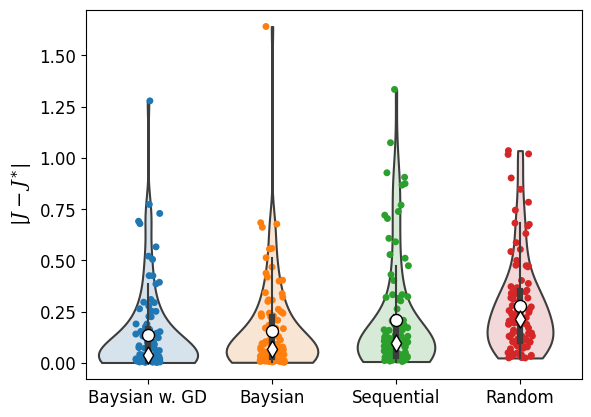

In [10]:
from matplotlib.colors import to_rgba

i_param = 0

fig, ax = plt.subplots(1,1)
sns.violinplot([loss_avg_over_runs[i_strat,:,-1,i_param].numpy() for i_strat in range(4)], ax=ax, zorder=10, inner='box', cut=0)
for vp in ax.collections[::2]:
    vp.set_facecolor(to_rgba(vp.get_facecolor(), alpha=0.2))
sns.stripplot([loss_avg_over_runs[i_strat,:,-1,i_param].numpy() for i_strat in range(4)], ax=ax, zorder=1)
ax.scatter(np.arange(4), [np.median(loss_avg_over_runs[i_strat,:,-1,i_param].numpy()) for i_strat in range(4)], 
           zorder=25, edgecolors='k', facecolors='w', marker='d', s=75, label='Median')
ax.scatter(np.arange(4), [np.mean(loss_avg_over_runs[i_strat,:,-1,i_param].numpy()) for i_strat in range(4)], 
           zorder=20, edgecolors='k', facecolors='w', marker='o', s=75, label='Mean')
ax.set_xticklabels(['Baysian w. GD', 'Baysian', 'Sequential', 'Random'])
ax.set_ylabel(rf'$|{ylabels[i_param]}-{ylabels[i_param]}^{{\ast}}|$')
# ax.legend(ncols=2)
ax.set_xlim([-0.5, 3.5])
# ax.set_ylim([-0.05, 1.75])

In [11]:
key = (0.2,2.0)
loss_avg_over_runs = results[key]['loss_avg_over_runs']
print(loss_avg_over_runs.shape)

torch.Size([4, 100, 41, 5])


Text(0.5, 1.0, '$w=0.2$ ps, $\\sigma=2.0$')

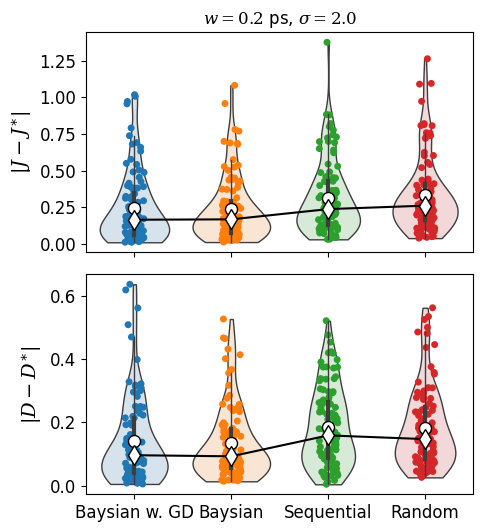

In [12]:
from matplotlib.colors import to_rgba

fig, axes = plt.subplots(
    2, 1, figsize=(5,6),
    sharex=True, gridspec_kw={'hspace': 0.1})

for i_param in [0,1]:
    ax = axes[i_param]
    sns.violinplot([loss_avg_over_runs[i_strat,:,-1,i_param].numpy() for i_strat in range(4)], ax=ax, zorder=10, inner='box', cut=0, linewidth=1)
    for vp in ax.collections[::2]:
        vp.set_facecolor(to_rgba(vp.get_facecolor(), alpha=0.2))
    sns.stripplot([loss_avg_over_runs[i_strat,:,-1,i_param].numpy() for i_strat in range(4)], ax=ax, zorder=1)
    # ax.scatter(np.arange(4), [np.median(loss_avg_over_runs[i_strat,:,-1,i_param].numpy()) for i_strat in range(4)], 
    #         zorder=25, edgecolors='k', facecolors='w', marker='d', s=75, label='Median')
    ax.plot(np.arange(4), [np.median(loss_avg_over_runs[i_strat,:,-1,i_param].numpy()) for i_strat in range(4)], 'k-d',
            zorder=25, markersize=10, markeredgecolor='k', markerfacecolor='w', label='Median')
    ax.scatter(np.arange(4), [np.mean(loss_avg_over_runs[i_strat,:,-1,i_param].numpy()) for i_strat in range(4)], 
            zorder=20, edgecolors='k', facecolors='w', marker='o', s=75, label='Mean')
    ax.set_xticklabels(['Baysian w. GD', 'Baysian', 'Sequential', 'Random'])
    ax.set_ylabel(rf'$|{ylabels[i_param]}-{ylabels[i_param]}^{{\ast}}|$')
    # ax.legend(ncols=2)
    ax.set_xlim([-0.5, 3.5])
    # ax.set_yscale('log')
axes[0].set_title(f"$w={key[0]}$ ps, $\sigma={key[1]}$")

In [13]:
loss_avg_over_runs_all = None
for key in results.keys():
    if loss_avg_over_runs_all is None:
        loss_avg_over_runs_all = results[key]['loss_avg_over_runs'].clone()
    else:
        loss_avg_over_runs_all += results[key]['loss_avg_over_runs']

loss_avg_over_runs_all /= len(results.keys())

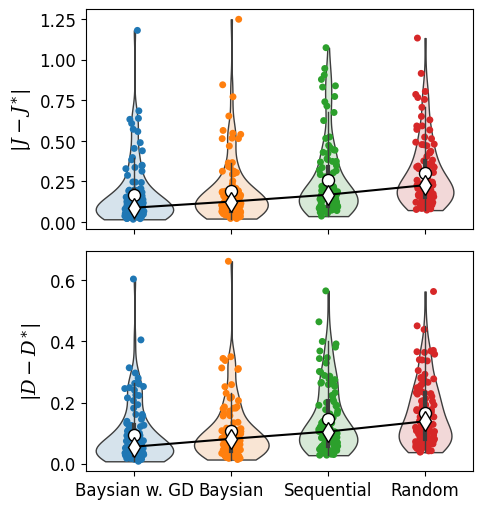

In [14]:
from matplotlib.colors import to_rgba

fig, axes = plt.subplots(
    2, 1, figsize=(5,6),
    sharex=True, gridspec_kw={'hspace': 0.1})

for i_param in [0,1]:
    ax = axes[i_param]
    sns.violinplot([loss_avg_over_runs_all[i_strat,:,-1,i_param].numpy() for i_strat in range(4)], ax=ax, zorder=10, inner='box', cut=0, linewidth=1)
    for vp in ax.collections[::2]:
        vp.set_facecolor(to_rgba(vp.get_facecolor(), alpha=0.2))
    sns.stripplot([loss_avg_over_runs_all[i_strat,:,-1,i_param].numpy() for i_strat in range(4)], ax=ax, zorder=1)
    # ax.scatter(np.arange(4), [np.median(loss_avg_over_runs[i_strat,:,-1,i_param].numpy()) for i_strat in range(4)], 
    #         zorder=25, edgecolors='k', facecolors='w', marker='d', s=75, label='Median')
    ax.plot(np.arange(4), [np.median(loss_avg_over_runs_all[i_strat,:,-1,i_param].numpy()) for i_strat in range(4)], 'k-d',
            zorder=25, markersize=10, markeredgecolor='k', markerfacecolor='w', label='Median')
    ax.scatter(np.arange(4), [np.mean(loss_avg_over_runs_all[i_strat,:,-1,i_param].numpy()) for i_strat in range(4)], 
            zorder=20, edgecolors='k', facecolors='w', marker='o', s=75, label='Mean')
    ax.set_xticklabels(['Baysian w. GD', 'Baysian', 'Sequential', 'Random'])
    ax.set_ylabel(rf'$|{ylabels[i_param]}-{ylabels[i_param]}^{{\ast}}|$')
    # ax.legend(ncols=2)
    ax.set_xlim([-0.5, 3.5])
    # ax.set_yscale('log')
# axes[0].set_title(f"$w={key[0]}$ ps, $\sigma={key[1]}$")